In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Example of the linear congruent method

Here we show a particularly bad version of the linear congruent method.

In [134]:
nrandom = 10
x = np.zeros(nrandom, dtype=np.int32)
M = np.int32(256)
c = np.int32(3)
a = np.int32(5)

In [135]:
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M
   print(x[indx + 1])

78
137
176
115
66
77
132
151
246


In [136]:
nrandom = 10000
x = np.zeros(nrandom, dtype=np.int32)
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M
x = np.float32(x) / np.float32(M)

If we look at the histogram of values between 0 and 255, it is fairly uniform (but with suspicious patterns).

In [137]:
xmin = 0.
xmax = 1.
nbin = 30
x_histogram, x_edges = np.histogram(x, range=[xmin, xmax], bins=nbin)
x_centers = xmin + (xmax - xmin) * (np.arange(nbin) + 0.5) / np.float32(nbin)

(-1.0, 420.0)

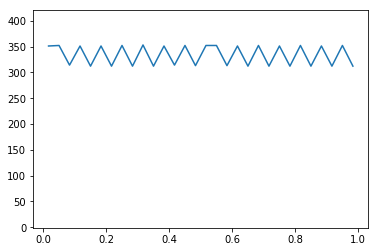

In [138]:
plt.plot(x_centers, x_histogram)
plt.ylim((-1., 420.))

But a definite pattern is noticable when you just plot the numbers!

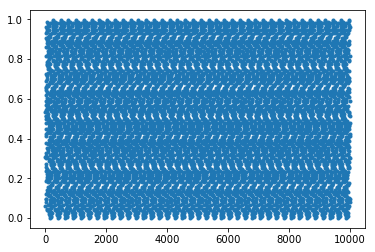

In [139]:
plt.plot(x, '.')

When you compare one number to its neighbor, there is a very definite pattern! These are not random at all!!

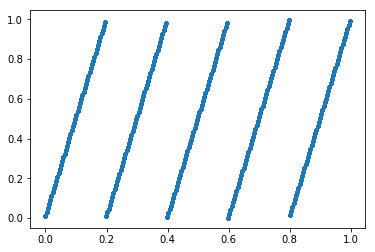

In [140]:
plt.plot(x[0:-2], x[1:-1], '.')

Now we use the more reasonable numbers quoted in Equations 4.11 and 4.12 in Landau. 

In [141]:
nrandom = 10
x = np.zeros(nrandom, dtype=np.int64)
M = np.int64(2**48)
# "0o" is the prefix for a base-8 number in Python
c = np.int64(0o13)
a = np.int64(0o273673163155)

In [142]:
nrandom = 10000
x = np.zeros(nrandom, dtype=np.int64)
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M
x = np.float64(x) / np.float64(M)

/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in long_scalars


In [144]:
xmin = 0.
xmax = 1.
nbin = 30
x_histogram, x_edges = np.histogram(x, range=[xmin, xmax], bins=nbin)
x_centers = xmin + (xmax - xmin) * (np.arange(nbin) + 0.5) / np.float32(nbin)

plt.plot(x_centers, x_histogram)
plt.ylim((-1., 420.))

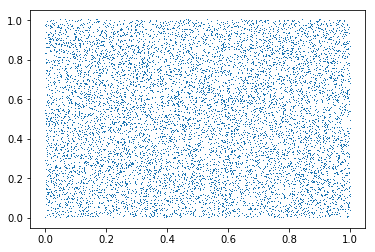

In [147]:
plt.plot(x[0:-2], x[1:-1], ',')

## Assessing randomness by looking at variance in bins

We can assess randomness using an ensemble of random samples.

In [211]:
nensembles = 1000
nper = 5000

In [212]:
x = np.zeros((nensembles, nper), dtype=np.int64)
xseed = 15
for iensemble in np.arange(nensembles):
    x[iensemble, 0] = xseed
    for indx in np.arange(nper - 1):
       x[iensemble, indx + 1] = (x[iensemble, indx] * a + c) % M
    xseed = x[iensemble, nper - 1]
x = np.float64(x) / np.float64(M)

/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in long_scalars


We can calculate the actual means and standard deviations using ufuncs.  

In [178]:
x_means = np.mean(x_histogram, axis=0)
x_stds = np.std(x_histogram, axis=0)

Then we can plot against the expected values.

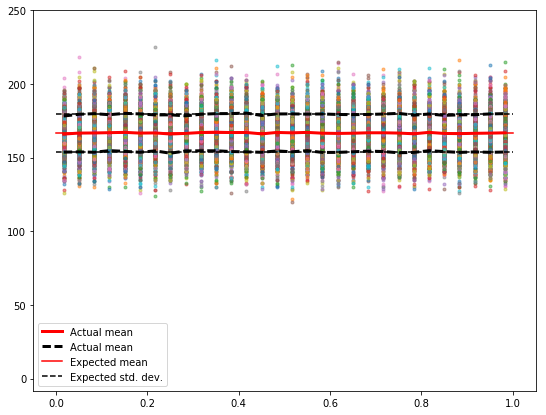

In [181]:
xmin = 0.
xmax = 1.
nbin = 30

plt.figure(figsize=(9,7))

nexpected = np.float32(nper) / np.float32(nbin)

x_histogram = np.zeros((nensembles, nbin), dtype=np.int32)
x_centers = xmin + (xmax - xmin) * (np.arange(nbin) + 0.5) / np.float32(nbin)

for iensemble in np.arange(nensembles):
    x_histogram_tmp, x_edges = np.histogram(x[iensemble, :],
                                            range=[xmin, xmax], bins=nbin)
    x_histogram[iensemble, :] = x_histogram_tmp
    plt.plot(x_centers, x_histogram[iensemble, :], '.', alpha=0.5)
    
plt.plot(x_centers, x_means, color='red', linewidth=3, label='Actual mean')
plt.plot(x_centers, x_means + x_stds, color='black', linestyle='dashed',
         linewidth=3, label='Actual mean')
plt.plot(x_centers, x_means - x_stds, color='black', linestyle='dashed',
         linewidth=3)

plt.plot([0., 1.], np.ones(2) * nexpected, color='red', label='Expected mean')
plt.plot([0., 1.], np.ones(2) * (nexpected + np.sqrt(nexpected)),
         linestyle='dashed', color='black', label='Expected std. dev.')
plt.plot([0., 1.], np.ones(2) * (nexpected - np.sqrt(nexpected)),
         linestyle='dashed', color='black')

plt.ylim(np.array([-0.05, 1.5]) * nexpected)
plt.xlabel('Bin center')
plt.legend(loc=3)

In [189]:
print(np.sqrt(1. / (nexpected * nensembles)))

0.00244948970541


Though impressive looking, never take a plot like the above at face value. You want to look at the ratios!

How close should they be? Well, if the standard deviation is $\sqrt{N_{\rm exp}}$, then the error in the mean is $\sqrt{N_{\rm exp} / N_{\rm ensemble}} = \sqrt{167 / 5000}$. So the fractional error in the mean is $1 / \sqrt{N_{\rm exp}N_{\rm ensemble}} = 0.0024$.

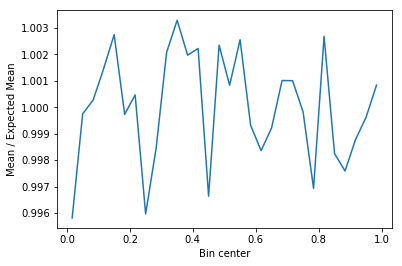

In [190]:
plt.plot(x_centers, x_means / nexpected)
plt.ylabel('Mean / Expected Mean')
plt.xlabel('Bin center')

## Assessing randomness by looking at correlations

We can evaluate the correlations within each ensemble to test randomness.

In [288]:
nk = 100
C = np.zeros((nensembles, nk), dtype=np.float64)
for iensemble in np.arange(nensembles):
    for k in np.arange(nk):
        C[iensemble, k] = (x[iensemble, 0: nper - (k + 1)] *
                           x[iensemble, (k + 1): nper]).sum() / np.float32(nper - k)

In [289]:
nk = 100
Chalf = np.zeros((nensembles, nk), dtype=np.float64)
for iensemble in np.arange(nensembles):
    for k in np.arange(nk):
        # Note "//" is an integer division
        Chalf[iensemble, k] = (x[iensemble, 0: nper // 2 - (k + 1)] *
                               x[iensemble, (k + 1): nper // 2]).sum() / np.float32(nper // 2 - k)

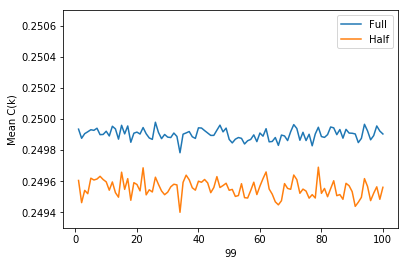

In [290]:
plt.plot(np.arange(nk) + 1, C.mean(axis=0), label='Full')
plt.plot(np.arange(nk) + 1, Chalf.mean(axis=0), label='Half')
plt.xlabel(k)
plt.ylabel('Mean C(k)')
plt.ylim((0.2493, 0.2507))
plt.legend()

We calculate the deviation around the expected mean, not the calculated mean.

In [291]:
Cstd = np.sqrt(((C - 0.25)**2).sum(axis=0) / C.shape[0])
Chalfstd = np.sqrt(((Chalf - 0.25)**2).sum(axis=0) / C.shape[0])

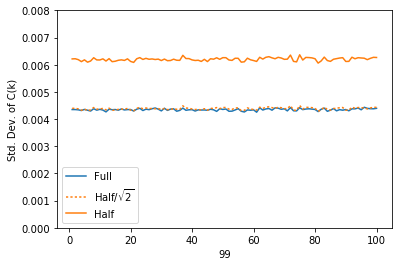

In [292]:
plt.plot(np.arange(nk) + 1, Cstd, color='C0', label='Full')
plt.plot(np.arange(nk) + 1, Chalfstd / np.sqrt(2.), color='C1',
         linestyle='dotted', label='Half/$\sqrt{2}$')
plt.plot(np.arange(nk) + 1, Chalfstd, color='C1', label='Half')
plt.xlabel(k)
plt.ylabel('Std. Dev. of C(k)')
plt.ylim(0., 0.008)
plt.legend()

We can test these properties with the default NumPy random number generator as well.

In [356]:
xr = np.random.random(size=(nensembles, nper))

In [357]:
nk = 100
C = np.zeros((nensembles, nk), dtype=np.float64)
for iensemble in np.arange(nensembles):
    for k in np.arange(nk):
        C[iensemble, k] = (xr[iensemble, 0: nper - (k + 1)] *
                           xr[iensemble, (k + 1): nper]).sum() / np.float32(nper - k)

In [358]:
nk = 100
Chalf = np.zeros((nensembles, nk), dtype=np.float64)
for iensemble in np.arange(nensembles):
    for k in np.arange(nk):
        # Note "//" is an integer division
        Chalf[iensemble, k] = (xr[iensemble, 0: nper // 2 - (k + 1)] *
                               xr[iensemble, (k + 1): nper // 2]).sum() / np.float32(nper // 2 - k)

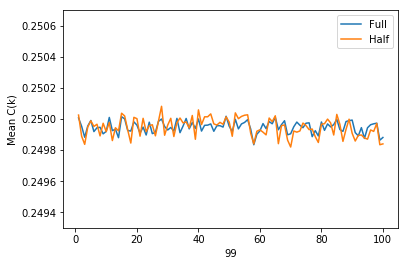

In [359]:
plt.plot(np.arange(nk) + 1, C.mean(axis=0), label='Full')
plt.plot(np.arange(nk) + 1, Chalf.mean(axis=0), label='Half')
plt.xlabel(k)
plt.ylabel('Mean C(k)')
plt.ylim((0.2493, 0.2507))
plt.legend()

In [360]:
Cstd = np.sqrt(((C - 0.25)**2).sum(axis=0) / C.shape[0])
Chalfstd = np.sqrt(((Chalf - 0.25)**2).sum(axis=0) / C.shape[0])

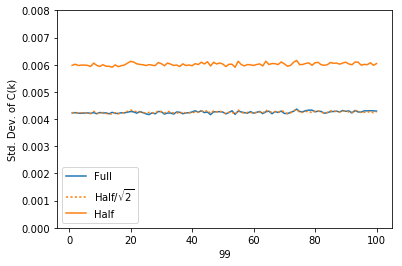

In [361]:
plt.plot(np.arange(nk) + 1, Cstd, color='C0', label='Full')
plt.plot(np.arange(nk) + 1, Chalfstd / np.sqrt(2.), color='C1',
         linestyle='dotted', label='Half/$\sqrt{2}$')
plt.plot(np.arange(nk) + 1, Chalfstd, color='C1', label='Half')
plt.xlabel(k)
plt.ylabel('Std. Dev. of C(k)')
plt.ylim(0., 0.008)
plt.legend()

## A random walk

A simple application is the random walk.

In [362]:
nwalkers = 1000
nsteps = 10000
steps = np.random.random(size=(nwalkers, nsteps)) - 0.5 

We can look at the distribution of steps, which is uniform across -0.5 to 0.5.

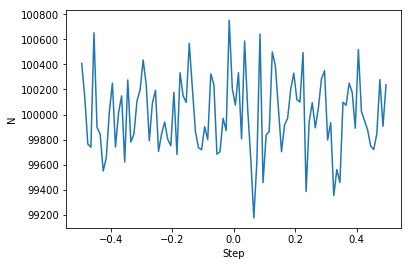

In [363]:
nbins = 100
steps_histogram, steps_edges = np.histogram(steps, bins=nbins, range=[-0.5, 0.5])
steps_centers = (steps_edges[0:nbins] + steps_edges[1:nbins + 1]) * 0.5
plt.plot(steps_centers, steps_histogram)
plt.xlabel('Step')
plt.ylabel('N')

The steps can be added into a path for each walker.

In [365]:
paths = steps.cumsum(axis=1)

The paths all start near zero and then spread out, slowly wandering away from zero.

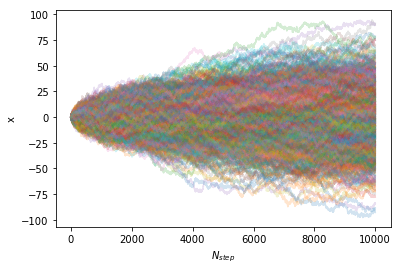

In [366]:
for indx in np.arange(nwalkers):
    plt.plot(paths[indx, :], alpha=0.2)
plt.xlabel('$N_{step}$')
plt.ylabel('x')

The distribution of position of walkers therefore grows with number of steps into the walk.

(-0.1, 2.8)

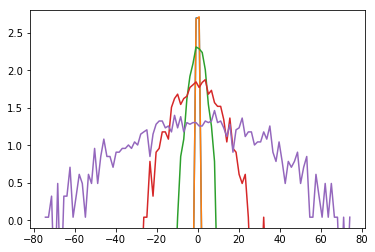

In [367]:
nbins = 100
dist0, edges = np.histogram(paths[:, 0], bins=nbins, range=[-75., 75])
dist1, edges = np.histogram(paths[:, 1], bins=nbins, range=[-75., 75])
dist10, edges = np.histogram(paths[:, 10], bins=nbins, range=[-75., 75])
dist100, edges = np.histogram(paths[:, 100], bins=nbins, range=[-75., 75])
dist1000, edges = np.histogram(paths[:, 1000], bins=nbins, range=[-75., 75])
dist9999, edges = np.histogram(paths[:, 9999], bins=nbins, range=[-75., 75])
cens = 0.5 * (edges[:-1] + edges[1:])
plt.plot(cens, np.log10(dist0 + 0.1))
plt.plot(cens, np.log10(dist1 + 0.1))
plt.plot(cens, np.log10(dist100 + 0.1))
plt.plot(cens, np.log10(dist1000 + 0.1))
plt.plot(cens, np.log10(dist9999 + 0.1))
plt.ylim((-0.1, 2.8))

The standard deviation of the distribution grows as the square root of the number of steps in an entirely predictable fashion.

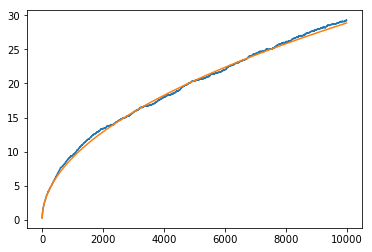

In [339]:
stds = np.std(paths, axis=0)
expected = np.sqrt(1. / 12. * (np.arange(nsteps) + 1))
plt.plot(stds)
plt.plot(expected)

Moreover, it becomes a Gaussian.

(-0.1, 2.8)

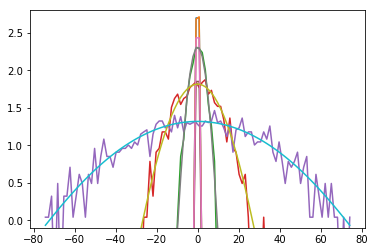

In [369]:
def model(indx):
    binsize = 150. / np.float32(nbins)
    model = (np.float32(nwalkers) *
             np.exp(- 0.5 * (cens / expected[indx])**2) /
             (np.sqrt(2. * np.pi) * expected[indx]) *
             binsize)
    return(model)
    
plt.plot(cens, np.log10(dist0 + 0.1))
plt.plot(cens, np.log10(dist1 + 0.1))
plt.plot(cens, np.log10(dist100 + 0.1))
plt.plot(cens, np.log10(dist1000 + 0.1))
plt.plot(cens, np.log10(dist9999 + 0.1))
plt.plot(cens, np.log10(model(0) + 0.1))
plt.plot(cens, np.log10(model(1) + 0.1))
plt.plot(cens, np.log10(model(100) + 0.1))
plt.plot(cens, np.log10(model(1000) + 0.1))
plt.plot(cens, np.log10(model(9999) + 0.1))
plt.ylim((-0.1, 2.8))

## Non-uniform random distributions 

Non-uniform random distributions can be generated from uniform random distributions, through transformations.

An example is generating an exponential distribution.

In [370]:
r = np.random.random(size=100000)
x = - np.log(r)

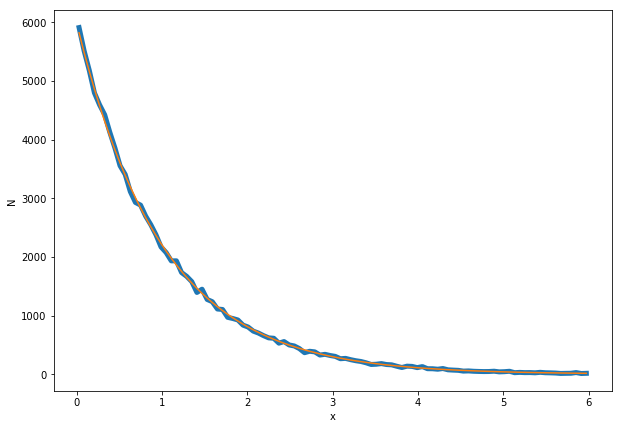

In [371]:
nbins = 100
dist, edges = np.histogram(x, bins=nbins, range=[0., 6.])
cens = 0.5 * (edges[:-1] + edges[1:])
plt.figure(figsize=(10, 7))
plt.plot(cens, dist, linewidth=5)
binsize = 6. / np.float32(nbins)
plt.plot(cens, len(x) * np.exp(- cens) * binsize)
plt.ylabel('N')
plt.xlabel('x')

The numpy.random module has a large selection of distributions.

In [374]:
np.random?